#  Convolutional Autoencoder

https://blog.keras.io/building-autoencoders-in-keras.html

Since our inputs are images, it makes sense to use convolutional neural networks (convnets) as encoders and decoders. In practical settings, autoencoders applied to images are always convolutional autoencoders --they simply perform much better.

Let's implement one. The encoder will consist in a stack of Conv2D and MaxPooling2D layers (max pooling being used for spatial down-sampling), while the decoder will consist in a stack of Conv2D and UpSampling2D layers.

In [1]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

To train it, we will use the original MNIST digits with shape (samples, 3, 28, 28), and we will just normalize pixel values between 0 and 1.

In [3]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data forma

Let's train this model for 50 epochs. For the sake of demonstrating how to visualize the results of a model during training, we will be using the TensorFlow backend and the TensorBoard callback.

First, let's open up a terminal and start a TensorBoard server that will read logs stored at /tmp/autoencoder.

Then let's train our model. In the callbacks list we pass an instance of the TensorBoard callback. After every epoch, this callback will write logs to /tmp/autoencoder, which can be read by our TensorBoard server.

In [4]:
from keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/50
469/469 [==============================] - 24s 6ms/step - loss: 0.6971 - val_loss: 0.6956
Epoch 2/50
469/469 [==============================] - 2s 4ms/step - loss: 0.6941 - val_loss: 0.6925
Epoch 3/50
469/469 [==============================] - 2s 5ms/step - loss: 0.6909 - val_loss: 0.6893
Epoch 4/50
469/469 [==============================] - 3s 6ms/step - loss: 0.6875 - val_loss: 0.6856
Epoch 5/50
469/469 [==============================] - 2s 5ms/step - loss: 0.6831 - val_loss: 0.6803
Epoch 6/50
469/469 [==============================] - 2s 4ms/step - loss: 0.6759 - val_loss: 0.6707
Epoch 7/50
469/469 [==============================] - 2s 4ms/step - loss: 0.6614 - val_loss: 0.6489
Epoch 8/50
469/469 [==============================] - 2s 4ms/step - loss: 0.6225 - val_loss: 0.5846
Epoch 9/50
469/469 [==============================] - 2s 4ms/step - loss: 0.5285 - val_loss: 0.4913
Epoch 10/50
469/469 [==============================] - 2s 4ms/step - loss: 0.4809 - val_loss: 0.479

The model converges to a loss of 0.094, significantly better than our previous models (this is in large part due to the higher entropic capacity of the encoded representation, 128 dimensions vs. 32 previously). Let's take a look at the reconstructed digits:

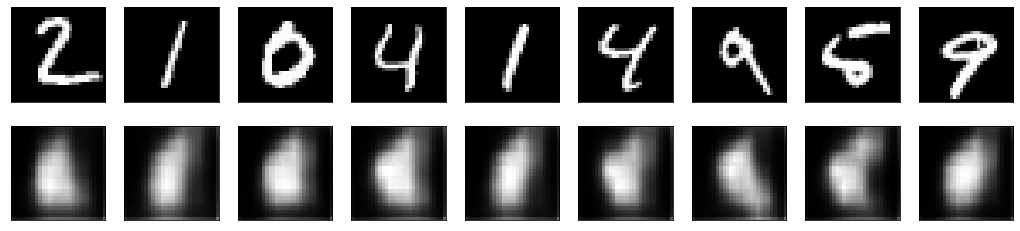

In [5]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Application to image denoising

Let's put our convolutional autoencoder to work on an image denoising problem. We will train the autoencoder to map noisy digits images to clean digits images.

Here's how we will generate synthetic noisy digits: we just apply a gaussian noise matrix and clip the images between 0 and 1.

In [6]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

Here's what the noisy digits look like:

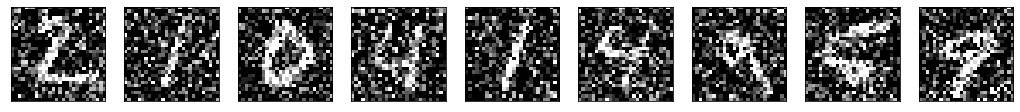

In [7]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1,n):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

If you squint you can still recognize them, but barely. Can our autoencoder learn to recover the original digits? Let's find out.

Compared to the previous convolutional autoencoder, in order to improve the quality of the reconstructed, we'll use a slightly different model with more filters per layer:

In [8]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

Let's train it for 100 epochs:

In [9]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])

Epoch 1/100
469/469 [==============================] - 3s 6ms/step - loss: 0.6707 - val_loss: 0.6510
Epoch 2/100
469/469 [==============================] - 2s 5ms/step - loss: 0.6226 - val_loss: 0.5908
Epoch 3/100
469/469 [==============================] - 2s 5ms/step - loss: 0.5535 - val_loss: 0.5247
Epoch 4/100
469/469 [==============================] - 2s 5ms/step - loss: 0.5078 - val_loss: 0.5023
Epoch 5/100
469/469 [==============================] - 2s 5ms/step - loss: 0.4947 - val_loss: 0.4942
Epoch 6/100
469/469 [==============================] - 2s 5ms/step - loss: 0.4869 - val_loss: 0.4866
Epoch 7/100
469/469 [==============================] - 2s 5ms/step - loss: 0.4793 - val_loss: 0.4787
Epoch 8/100
469/469 [==============================] - 2s 5ms/step - loss: 0.4713 - val_loss: 0.4703
Epoch 9/100
469/469 [==============================] - 2s 5ms/step - loss: 0.4627 - val_loss: 0.4613
Epoch 10/100
469/469 [==============================] - 3s 5ms/step - loss: 0.4533 - val_lo

Now let's take a look at the results. Top, the noisy digits fed to the network, and bottom, the digits are reconstructed by the network.

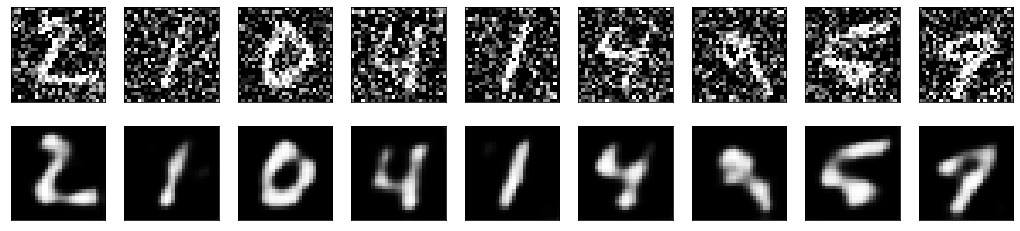

In [10]:
decoded_imgs = autoencoder.predict(x_test_noisy)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()